# BME-230B Spring 2019 HW 2 Question 
Andrew Davidson aedavids@ucsc.edu

supposedly it took Andrew and Yianni 3 days to write the louvain clustering algo. The inner loop is about 100 lines.

Given we only get 10 pts for the implementation and we are running out of time lets use the scanpy version for now

## <span style="color:red">TODO implement 2.a Louvain Clustering and 2.d</span>

- ref
    * [scanpy.tl.umap](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.tl.umap.html)
    * [scanpy.api.pp.neighbors](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.api.pp.neighbors.html?highlight=neighbors)
    * [scanpy.pl.umap](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.pl.umap.html#scanpy.pl.umap)
    * [scanpy.tl.louvain](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.tl.louvain.html#scanpy.tl.louvain)
    * [anndata](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html)
        + "uns" stands for unstructured data
        + "obs" are panda data frame observations 
        + "obsm key-indexed multi-dimensional observations

In [1]:
from euclid_knn import knnG
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy.api as sc
import scanpy
print("scanpy.__version__:{}".format(scanpy.__version__))

scanpy.__version__:1.4.1


## 2.b. [5 pts] 
Turn in a UMAP plot of the combined dataset as you did in question #1, but
this time, color the cells by their Louvain cluster assignments determined for each cell
within each batch as a different color in each plot.

In [2]:
%%time
anndata = sc.read("PBMC.merged.h5ad")
knnG(anndata, n_neighbors=12)

emptying .uns...
CPU times: user 2min 23s, sys: 2.42 s, total: 2min 25s
Wall time: 2min 18s


In [3]:
%%time
# resolution : float, None
# For the default flavor ('vtraag'), you can provide a resolution 
# (higher resolution means finding more and smaller clusters), 
# which defaults to 1.0. See “Time as a resolution parameter” in [Lambiotte09].
scanpy.tl.louvain(anndata, resolution=1)

CPU times: user 2.05 s, sys: 48.9 ms, total: 2.1 s
Wall time: 1.62 s


In [4]:
plt.figure(figsize=(10,10))
scanpy.tl.umap(anndata)

<Figure size 720x720 with 0 Axes>

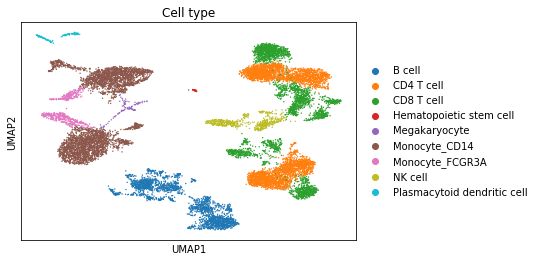

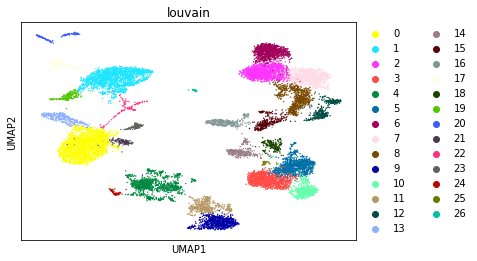

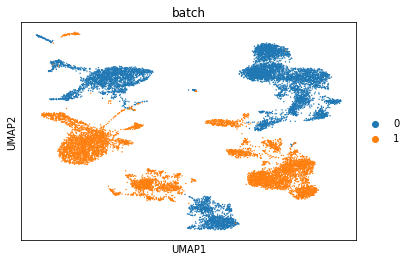

In [5]:
scanpy.pl.umap(anndata, color=['Cell type'])
scanpy.pl.umap(anndata, color=["louvain"])
scanpy.pl.umap(anndata, color=["batch"])

## 2.c. [5 pts] 
Turn in a table that lists each cluster and its best-matching cell type
annotation. The table should contain the cluster number and its best matching cell-type
annotation based on the hypergeometric analysis.

In [6]:
#anndata.obs['louvain'].head(3)

In [7]:
#anndata.obs.loc[:,['louvain', 'Cell type']].head()

In [8]:
df = anndata.obs.loc[:,['louvain', 'Cell type']]
df.head()
grouped = df.groupby(['louvain', 'Cell type'])
# grouped.describe()
grouped['louvain'].count()

louvain  Cell type                  
0        B cell                            1
         Megakaryocyte                     6
         Monocyte_CD14                  1937
         Monocyte_FCGR3A                  19
1        Monocyte_CD14                  1702
         Monocyte_FCGR3A                  24
2        CD4 T cell                     1351
         CD8 T cell                       12
3        CD4 T cell                     1173
         CD8 T cell                       10
4        B cell                         1102
         Monocyte_CD14                     2
5        CD4 T cell                     1007
         CD8 T cell                        3
6        CD4 T cell                        5
         CD8 T cell                      933
7        CD4 T cell                      899
         CD8 T cell                       19
8        CD4 T cell                        4
         CD8 T cell                      748
9        B cell                          744
10       CD4 T cel

## 2.d. [5 pts] 
Turn in a list of top 5 pathways for each cluster in each dataset. You should
use the gene expression signature of each cluster to find an associated pathway. A gene
signature for a cluster represents the gene expression levels for a characteristic cell that is a
member of the cluster. Use the centroid 𝞵 i of the i th cluster as the signature. Compute the
centroids for each cluster in each dataset. You will next derive a gene-signature based
annotation for each cluster using these centroids. Use a list of Gene Ontology Biological
Process categories (provided in the Resources section at the top of this homework) and your
signatures to perform an all-against-all Gene Set Enrichment Analysis (GSEA). Turn in a table
that lists the top 5 pathways for each cluster

### <span style="color:red">aedwip</span>
- def select cells in cluster
- def calc centroid "get signature"

In [9]:
anndata.obs['louvain'].head(3)

index
data_3p-AAACCTGAGCATCATC-0    9
data_3p-AAACCTGAGCTAGTGG-0    7
data_3p-AAACCTGCACATTAGC-0    2
Name: louvain, dtype: category
Categories (27, object): [0, 1, 2, 3, ..., 23, 24, 25, 26]

In [12]:
type(anndata.obs['louvain'])

pandas.core.series.Series

In [19]:
type(anndata.obsm['X_pca'])

numpy.ndarray

In [21]:
anndata.obsm['X_pca'].shape

(15476, 50)

In [17]:
# does not work
#aedwipPd = pd.DataFrame(anndata.obs['louvain'], anndata.obsm['X_pca'])

In [38]:
# for a cluster select get the int idx for its members
aedwipPd = pd.DataFrame(anndata.obs['louvain'])
aedwipPd.head()

,louvain
index,
data_3p-AAACCTGAGCATCATC-0,9
data_3p-AAACCTGAGCTAGTGG-0,7
data_3p-AAACCTGCACATTAGC-0,2
data_3p-AAACCTGCACTGTTAG-0,1
data_3p-AAACCTGCATAGTAAG-0,1


In [42]:
# cluster values are chars not ints
cluster9Cells = aedwipPd['louvain'] == '9'
cluster9Cells.head()

index
data_3p-AAACCTGAGCATCATC-0     True
data_3p-AAACCTGAGCTAGTGG-0    False
data_3p-AAACCTGCACATTAGC-0    False
data_3p-AAACCTGCACTGTTAG-0    False
data_3p-AAACCTGCATAGTAAG-0    False
Name: louvain, dtype: bool

In [43]:
aedwipPd.loc[cluster9Cells, :].head()

,louvain
index,
data_3p-AAACCTGAGCATCATC-0,9
data_3p-AAACGGGCACCTCGGA-0,9
data_3p-AAACGGGCAGTAAGAT-0,9
data_3p-AAAGATGGTGGTGTAG-0,9
data_3p-AAAGATGGTGTGACCC-0,9


In [44]:
aedwipPd.loc[cluster9Cells, :].count()

louvain    744
dtype: int64

In [72]:
xxx = aedwipPd.loc[cluster9Cells, :]
aedwipPd.index.get_loc('data_3p-AAAGATGGTGTGACCC-0')

49

In [76]:
xxx.index.values

array(['data_3p-AAACCTGAGCATCATC-0', 'data_3p-AAACGGGCACCTCGGA-0',
       'data_3p-AAACGGGCAGTAAGAT-0', 'data_3p-AAAGATGGTGGTGTAG-0',
       'data_3p-AAAGATGGTGTGACCC-0', 'data_3p-AAAGCAATCAGCGACC-0',
       'data_3p-AAAGTAGAGCTACCTA-0', 'data_3p-AAATGCCTCACCAGGC-0',
       'data_3p-AACACGTAGAGGTTGC-0', 'data_3p-AACACGTTCTCTGAGA-0',
       'data_3p-AACCATGAGAAGAAGC-0', 'data_3p-AACCATGTCTCGTATT-0',
       'data_3p-AACCGCGGTGTCCTCT-0', 'data_3p-AACCGCGGTTGTGGCC-0',
       'data_3p-AACTCTTGTCATATGC-0', 'data_3p-AACTCTTTCGGACAAG-0',
       'data_3p-AACTGGTTCACAAACC-0', 'data_3p-AACTTTCCAAGCGCTC-0',
       'data_3p-AACTTTCCAGTCAGAG-0', 'data_3p-AACTTTCCAGTCAGCC-0',
       'data_3p-AACTTTCCATCGATTG-0', 'data_3p-AAGACCTCACAAGACG-0',
       'data_3p-AAGCCGCCACATGTGT-0', 'data_3p-AAGCCGCCACTGCCAG-0',
       'data_3p-AAGCCGCTCACATAGC-0', 'data_3p-AAGGCAGCATCTCCCA-0',
       'data_3p-AAGGTTCAGCTCTCGG-0', 'data_3p-AAGGTTCGTGCCTGTG-0',
       'data_3p-AAGTCTGTCGACGGAA-0', 'data_3p-AATCGGTGTGGCAAAC

In [62]:
aaaPD.index.astype('int64')

TypeError: Cannot cast Index to dtype int64

## next hack fail


In [88]:
numGenes = anndata.obsm['X_pca'].shape[1]
colNames = ['g' + str(i) for i in range(numGenes)]
#colNames = ['louvain'] + colNames

In [91]:
# df = pd.DataFrame(anndata.obs['louvain'], 
#                   anndata.obsm['X_pca'],
#                  columns=colNames)
df = pd.DataFrame(anndata.obsm['X_pca'], columns=colNames)
df['louvain'] = anndata.obs['louvain']
df.head()

,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,...,g41,g42,g43,g44,g45,g46,g47,g48,g49,louvain
0,-4.685095,10.949246,-0.899550,-5.534255,-1.076634,-0.393064,0.339972,0.685257,-1.024560,-1.064697,...,-0.697538,-0.453958,-0.831584,1.072296,-0.064361,0.750728,-2.531698,-0.398070,1.722768,NaN
1,-5.159005,-3.407968,-4.748698,-1.297273,0.921254,-0.196652,0.049248,-2.925513,-0.857607,2.568807,...,-0.893754,-0.533572,-0.077598,-0.941502,0.027183,0.014783,0.140097,-0.448356,0.240256,NaN
2,-5.781177,-2.154723,-5.373779,-2.994467,-0.314731,-0.403034,1.008857,2.177212,-1.041224,0.867156,...,0.455880,0.093656,0.373522,-0.079528,0.166545,0.164325,0.632318,-0.989429,-0.313502,NaN
3,13.976912,0.257603,-0.888098,-2.963450,-0.008805,1.184836,2.249222,-2.124154,3.897266,-0.917768,...,-1.000794,0.181196,0.307928,-1.129013,0.167261,1.352772,-0.131515,0.423014,0.274667,NaN
4,15.095696,-0.516300,-1.886217,-4.895507,-0.220331,0.854100,-4.034896,-1.603160,3.706747,-0.357228,...,-0.297229,-0.741645,-0.595248,-0.621781,-0.201137,-1.231228,-0.271943,1.134056,-0.624911,NaN


## Hack
1. create a data frame we can use to select the cells in a given cluster
    a. we need the index value we can use to to get the cell's expression
    values from the numpy array anndata.obsm['X_pca'].shape

In [101]:
# create a data frame that we can use to select the index of cells in a given
# cluster. The index corresponds to the ros in 
numCells = anndata.obs['louvain'].size
numCells

numpyArrayIdx = [i for i in range(numCells)]
d = {'louvain':anndata.obs['louvain'], 'npIdx':numpyArrayIdx }
louvainDF = pd.DataFrame(data=d)
louvainDF.head()

,louvain,npIdx
index,,
data_3p-AAACCTGAGCATCATC-0,9,0
data_3p-AAACCTGAGCTAGTGG-0,7,1
data_3p-AAACCTGCACATTAGC-0,2,2
data_3p-AAACCTGCACTGTTAG-0,1,3
data_3p-AAACCTGCATAGTAAG-0,1,4


In [102]:
cluster9Cells = louvainDF['louvain'] == '9'
cluster9Cells.head()

index
data_3p-AAACCTGAGCATCATC-0     True
data_3p-AAACCTGAGCTAGTGG-0    False
data_3p-AAACCTGCACATTAGC-0    False
data_3p-AAACCTGCACTGTTAG-0    False
data_3p-AAACCTGCATAGTAAG-0    False
Name: louvain, dtype: bool

In [103]:
louvainDF.loc[cluster9Cells, :].count()

louvain    744
npIdx      744
dtype: int64

In [104]:
louvainDF.loc[cluster9Cells, :].head()

,louvain,npIdx
index,,
data_3p-AAACCTGAGCATCATC-0,9,0
data_3p-AAACGGGCACCTCGGA-0,9,23
data_3p-AAACGGGCAGTAAGAT-0,9,25
data_3p-AAAGATGGTGGTGTAG-0,9,48
data_3p-AAAGATGGTGTGACCC-0,9,49
